In [1]:
# 2 dimensional Nearly Constant Velocity Model
# Nonlinear observation scheme measuring range and elevation.
# CD-EKF in Case 2.
# 10 June 2016

In [2]:
# Import the required libraries
import numpy as np
import math
from numpy import linalg
import scipy.linalg
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Define variables for the simulation
dt = 0.1 ; #[s]
t = np.arange(0,40,dt,dtype=float) # [s]

In [4]:
dimensionality = 2; # 2 dimensional problem
nStates = 2; # 2 states per dimension. position,velocity and acceleration
nVars = nStates*dimensionality; 
x_state = np.zeros([nVars,len(t)],dtype=float);

def fn_Generate_STM_polynom(zeta,nStates):
    # fn_Generate_STM_polynom creates the state transition matrix for polynomial models 
    # of degree (nStates-1) over a span of transition of zeta [s].
    # Polynomial models are a subset of the class of constant-coefficient linear DEs.
    # Refer to: Tracking Filter Engineering, Norman Morrison.
    stm = np.eye(nStates,dtype=float);
    for yindex in range (0,nStates):
        for xindex in range (yindex,nStates): # STM is upper triangular
            stm[yindex,xindex] = np.power(zeta,xindex-yindex)/float(math.factorial(xindex-yindex));
    return stm;     

def fn_Generate_STM_polynom_2D(zeta,nStates,dimensionality):
    # fn_Generate_STM_polynom_2D generates the full state transition matrix for 
    # the required dimensionality.
    stm = fn_Generate_STM_polynom(dt,nStates);
    stm2 = fn_Create_Concatenated_Block_Diag_Matrix(stm,dimensionality-1);
    return stm2;

def fn_Create_Concatenated_Block_Diag_Matrix(R,stacklen):
    # fn_Create_Concatenated_Block_Diag_Matrix creates a block diagonal matrix of size (stacklen) x (stacklen)
    # whose diagonal blocks are copies of the matrix R.
    L = [R]; 
    for index in range (0,stacklen):
        L.append(R);
        ryn = scipy.linalg.block_diag(*L);
    return ryn;

In [5]:
def fnH(X):
    # Nonlinear measurement function
    # Sensor measures range and angle.
    Y = np.zeros([2],dtype=float);
    Y[0] = np.linalg.norm(X); # range
    Y[1] = np.arctan2(X[1],X[0]); # angle
    return Y

def fnJacobianH(X):
    # Jacobian of nonlinear measurement function fnH
    Y = fnH(X);
    dy = np.zeros([2,2],dtype=float);
    dy[0,0] = X[0]/Y[0];
    dy[0,1] =  X[1]/Y[1];
    dy[1,0] = -X[1]/Y[0]**2;
    dy[1,1] = X[0]/Y[0]**2;
    return dy

In [6]:
# Initialize  state vector
x_state[:,0] = np.array([1,1.2,2,1.2],dtype=float); # x pos, x vel, y pos, y vel
# Find continuous-time process covariance matrix, then discretize it.
qtilde = 0.001*x_state[3,0]/np.sqrt(dt); # Choice of process noise intensity.
Qc01 = np.power(dt,3)/3;
Qc02 = np.square(dt)/2;
Qc = np.array([[Qc01,Qc02],[Qc02,dt]],dtype=float);
Qd = Qc*np.square(qtilde);
Qd2 = fn_Create_Concatenated_Block_Diag_Matrix(Qd,dimensionality-1);

# Measurement noise covariance matrix
R = np.diag([np.square(0.1),np.square(0.01)]); 
y_meas = np.zeros([2,len(t)],dtype=float); # measurement vector.

# Initial estimate of state vector
m0 = x_state[:,0] + np.random.multivariate_normal([0,0,0,0],Qd2);
P0 = np.diag([100.0,10.0,100.0,10]);  # Initial covariance matrix estimate, indicating high uncertainty.  
pos = np.array([m0[0],m0[2]],dtype=float);
y_meas[:,0] = fnH(pos); # initialize measurement vector.
stm2 = fn_Generate_STM_polynom_2D(dt,nStates,dimensionality);

for index in range (1,len(t)):
    wn = np.random.multivariate_normal([0,0,0,0],Qd2);
    x_state[:,index] = np.dot( stm2,x_state[:,index-1] ) + wn;
    # sensor measurements are contaminated with awgn of covariane R.
    vn = np.random.multivariate_normal([0,0],R);
    pos = np.array([x_state[0,index],x_state[2,index]],dtype=float);
    y_meas[:,index] = fnH(pos) + vn;
    

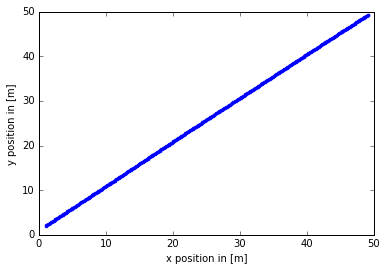

In [7]:
fig = plt.figure()
plt.plot(x_state[0,:],x_state[2,:],'b.')
plt.ylabel('y position in [m]')
plt.xlabel('x position in [m]')
plt.show()

In [8]:
## extended Kalman filter functions ###########################################
def fnEKF_predict( F,A, m, P, Q):
    # fnKF_predict implements the extended Kalman Filter predict step.
    # F is the nonlinear dynamics function.
    # A is the Jacobian of the function F evaluated at m.
    # m is the mean, P is the covariance matrix.
    # process noise: Q matrix
    m_pred = np.dot(F,m);
    P_pred = np.add(np.dot(np.dot(A,P),np.transpose(A)),Q);
    # m_pred and P_pred are the predicted mean state vector and covariance
    # matrix at the current time step before seeing the measurement.
    return m_pred, P_pred

def fnEKF_update(m_minus, P_minus, y,H,M, R ):
    # m_minus,P_minus: state vector and covariance matrix
    # y is the measurement vector. H is the nonlinear measurement function and
    # M is its Jacobian. R is the measurement covariance matrix.
    innovation_mean = H;
    prediction_covariance = np.add(R ,np.dot(M,np.dot(P_minus,np.transpose(M))));
    KalmanGain = np.dot(np.dot(P_minus,np.transpose(M)),np.linalg.inv(prediction_covariance));

    # Calculate estimated mean state vector and its covariance matrix.
    m = m_minus + np.dot(KalmanGain , (y - innovation_mean));
    
    P = np.subtract(P_minus,np.dot(np.dot(KalmanGain,prediction_covariance),np.transpose(KalmanGain)));
    return m,P

In [9]:
## Filter the sensor data  ###################################################
x_state_hat = np.zeros([4,len(t)],dtype=float)
x_state_hat[:,0] = m0;
P_hat = np.zeros([4,4,len(t)],dtype=float);
P_hat[:,:,0] = P0;

A = np.zeros([4,4],dtype=float);
A[0,1] =1.0; A[1,3] = 1.0;

for index in range (1,x_state_hat.shape[1]-1):
    m_pred,P_pred = fnEKF_predict( stm2,stm2,x_state_hat[:,index-1], P_hat[:,:,index-1], Qd2);
    pos = np.array([m_pred[0],m_pred[2]],dtype=float);
    Htilde = fnJacobianH(pos);
    H = np.zeros([2,4],dtype=float);
    H[:,0] = Htilde[:,0]; H[:,2] =Htilde[:,1];
    x_state_hat[:,index],P_hat[:,:,index] = fnEKF_update(m_pred, P_pred, y_meas[:,index],fnH(pos),H, R );

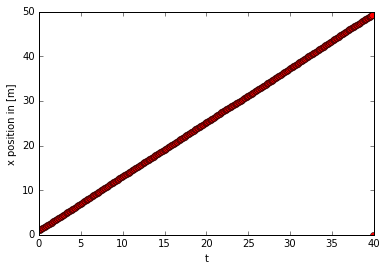

In [10]:
fig = plt.figure()
plt.plot(t,x_state[0,:],'b.')
plt.plot(t,x_state_hat[0,:],'ro')
plt.ylabel('x position in [m]')
plt.xlabel('t')
plt.show()

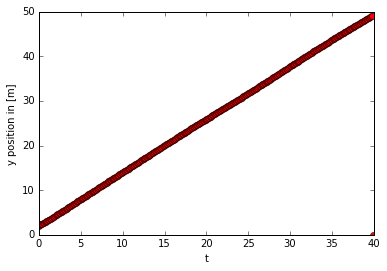

In [11]:
fig = plt.figure()
plt.plot(t,x_state[2,:],'b.')
plt.plot(t,x_state_hat[2,:],'ro')
plt.ylabel('y position in [m]')
plt.xlabel('t')
plt.show()

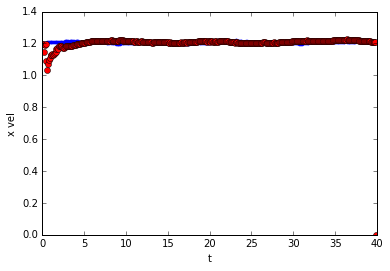

In [12]:
fig = plt.figure()
plt.plot(t,x_state[1,:],'b.')
plt.plot(t,x_state_hat[1,:],'ro')
plt.ylabel('x vel')
plt.xlabel('t')
plt.show()

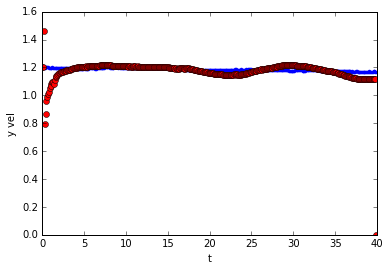

In [13]:
fig = plt.figure()
plt.plot(t,x_state[3,:],'b.')
plt.plot(t,x_state_hat[3,:],'ro')
plt.ylabel('y vel')
plt.xlabel('t')
plt.show()

In [14]:
## Compute the RMS Error ######################################################
epsilon = np.zeros_like(y_meas,dtype=float);
squared_error = np.zeros_like(t,dtype=float);
Rinv = np.linalg.inv(R);
for index in range (0,x_state_hat.shape[1]-1):
    pos = np.array([x_state_hat[0,index],x_state_hat[2,index]],dtype=float);
    epsilon[:,index] = np.subtract(y_meas[:,index],fnH(pos));
    squared_error[index] = np.dot(np.dot(np.transpose(epsilon[:,index]),Rinv),epsilon[:,index]);
mse = np.sum(squared_error)/float(np.shape(epsilon)[0]*np.shape(squared_error)[0]);
rmse = math.sqrt(mse);
print rmse

1.15263709945
